In [1]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [2]:
!wget $url -o download_week4.log

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc

from sklearn.model_selection import KFold

/home/mbock/venvs/jupiterlab_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('course_lead_scoring.csv')
df.head(2).T

,0,1
lead_source,paid_ads,social_media
industry,NaN,retail
number_of_courses_viewed,1,1
annual_income,79450.0,46992.0
employment_status,unemployed,employed
location,south_america,south_america
interaction_count,4,1
lead_score,0.94,0.8
converted,1,0


## Data Preparation

In [5]:
def missing_replace(l, val):
    for col in l:
        df[col].fillna(val, inplace=True)
    return df

In [6]:
l = [col for col in df.columns if df[col].dtypes =='O' and df[col].isna().sum() != 0]
val = 'NA'
df = missing_replace(l, val)

/tmp/ipykernel_234515/1988618402.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(val, inplace=True)


In [7]:
l = [col for col in df.columns if df[col].dtypes !='O' and df[col].isna().sum() != 0]
val = 0.0
df = missing_replace(l, val)

/tmp/ipykernel_234515/1988618402.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(val, inplace=True)


In [8]:
# Numeric columns
num_cols = [col for col in df.columns if df[col].dtypes != 'O']
num_columns = num_cols[:-1]
# Categoric columns
categorical_columns = list(col for col in df.columns if df[col].dtypes == 'O')

In [9]:
num_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [10]:
categorical_columns

['lead_source', 'industry', 'employment_status', 'location']

## Split Data

In [11]:
data_full_train, data_test = train_test_split(df, test_size=0.2, random_state=1)
data_train, data_val = train_test_split(data_full_train, test_size=0.25, random_state=1)

In [12]:
len(data_train) + len(data_test) + len(data_val) - len(df)

0

In [13]:
data_full_train = data_full_train.reset_index(drop=True)
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)

In [14]:
y_full_train = data_full_train.converted.values
y_train = data_train.converted.values
y_test = data_test.converted.values
y_val = data_val.converted.values

In [15]:
del data_train['converted']
del data_test['converted']
del data_val['converted']

## Question 1: ROC AUC feature importance

In [16]:
for col in num_columns:
    auc = roc_auc_score(y_train, data_train[col])
    print('col: %s --> auc = %.2f' % (col, auc))

col: number_of_courses_viewed --> auc = 0.76
col: annual_income --> auc = 0.55
col: interaction_count --> auc = 0.74
col: lead_score --> auc = 0.61


---

### train model

In [17]:
# train function
def train(df_train, y_train, c=1.0):
    dicts = df_train[categorical_columns + num_columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    mo = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    mo.fit(X_train, y_train)

    return dv, mo


# Predict function
def predict(df, dv, modl):
    dicts = df[categorical_columns + num_columns].to_dict(orient='records')
    X = dv.fit_transform(dicts)
    y_pred = modl.predict_proba(X)[:, 1]
    return y_pred

In [18]:
dv, model = train(data_train, y_train)
y_pred = predict(data_val, dv, model)

## Question 2: Training the model

In [19]:
auc = roc_auc_score(y_val, y_pred)
print('AUC = %.3f' % auc)

AUC = 0.817


## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [44]:
scores_ = []
threshods = np.arange(0.0, 1.01, 0.01) 


for t in threshods:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores_.append((t, tp, fp, fn, tn))

In [21]:
columns = ['threshods', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores_, columns=columns)



In [29]:
df_scores['precision'] = np.where(
    (df_scores['tp'] + df_scores['fp']) > 0,
    (df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])).round(2),
    0
)
df_scores['recall'] = (df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])).round()

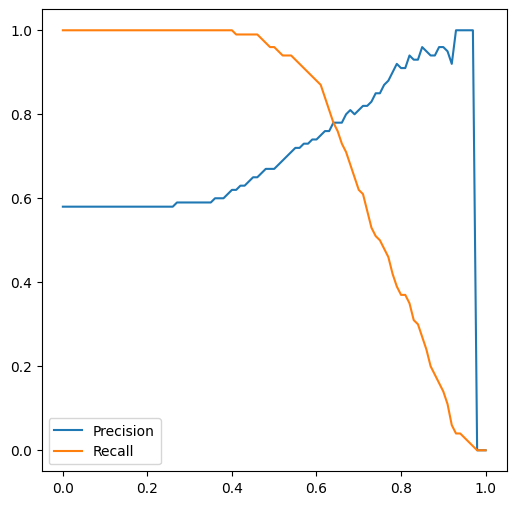

In [23]:
plt.figure(figsize=(6, 6))
plt.plot(df_scores.threshods, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshods, df_scores['recall'], label='Recall')
plt.legend()
plt.show()

In [43]:
# indices où la différence est exactement 0
diff = abs(df_scores['precision'] - df_scores['recall'])
indices_zero = diff[diff == 0.0].index
print(indices_zero)
print(indices_zero.min())

Index([64, 98, 99, 100], dtype='int64')
64


In [36]:
df_scores.loc[indices_zero, 'threshods']

np.float64(0.64)

In [41]:
df_scores[::4].tail(10)

,threshods,tp,fp,fn,tn,precision,recall
64,0.64,134,38,37,84,0.78,0.78
68,0.68,116,28,55,94,0.81,0.68
72,0.72,97,21,74,101,0.82,0.57
76,0.76,82,12,89,110,0.87,0.48
80,0.80,64,6,107,116,0.91,0.37
84,0.84,52,4,119,118,0.93,0.30
88,0.88,31,2,140,120,0.94,0.18
92,0.92,11,1,160,121,0.92,0.06
96,0.96,3,0,168,122,1.00,0.02
100,1.00,0,0,171,122,0.00,0.00


## Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. 

That's why they are often combined into the F1 score - a metrics that takes into account both

In [49]:
df_scores['f1_score'] = np.where(
    (df_scores['precision'] + df_scores['recall']) > 0,
    (2 * (df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])).round(2),
    0
)

df_scores.head()


,threshods,tp,fp,fn,tn,precision,recall,f1_score
0,0.00,171,122,0,0,0.58,1.0,0.73
1,0.01,171,122,0,0,0.58,1.0,0.73
2,0.02,171,122,0,0,0.58,1.0,0.73
3,0.03,171,122,0,0,0.58,1.0,0.73
4,0.04,171,122,0,0,0.58,1.0,0.73


In [51]:
max_f1_score = df_scores['f1_score'].values.max()
max_f1_score

np.float64(0.81)

In [53]:
df_scores.loc[max_f1_score*100, 'threshods']

np.float64(0.81)

## Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
```KFold(n_splits=5, shuffle=True, random_state=1)```
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters:
```LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)```
- Use AUC to evaluate the model on validation

In [58]:
scores_kfold = []
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)


for train_idx, val_idx in tqdm(kfold.split(data_full_train), total=n_splits):
    data_train_kfold = data_full_train.iloc[train_idx]
    data_val_kfold = data_full_train.iloc[val_idx]
        
    y_train_kfold = data_train_kfold.converted.values
    y_val_kfold = data_val_kfold.converted.values
        
    dv, model_kfold = train(data_train_kfold, y_train_kfold, c=1.0)
        
    y_pred_kfold = predict(data_val_kfold, dv, model_kfold)
        
    auc = roc_auc_score(y_val_kfold, y_pred_kfold)
    scores_kfold.append(auc)

    print('std = %.3f' % np.std(scores_kfold))

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.34it/s]

std = 0.000
std = 0.033
std = 0.040
std = 0.035
std = 0.036


## Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [62]:
n_splits = 5
for c in [0.000001, 0.001, 1.]:
    scores_kfold = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in tqdm(kfold.split(data_full_train), total=n_splits):
        data_train_kfold = data_full_train.iloc[train_idx]
        data_val_kfold = data_full_train.iloc[val_idx]
        
        y_train_kfold = data_train_kfold.converted.values
        y_val_kfold = data_val_kfold.converted.values
        
        dv, model_kfold = train(data_train_kfold, y_train_kfold, c)
        
        y_pred_kfold = predict(data_val_kfold, dv, model_kfold)
        
        auc = roc_auc_score(y_val_kfold, y_pred_kfold)
        scores_kfold.append(auc)

        print('C=%s , mean_score = %.3f +- std = %.3f' % (c, np.mean(scores_kfold),  np.std(scores_kfold)))

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.12it/s]


C=1e-06 , mean_score = 0.557 +- std = 0.000
C=1e-06 , mean_score = 0.538 +- std = 0.019
C=1e-06 , mean_score = 0.555 +- std = 0.029
C=1e-06 , mean_score = 0.556 +- std = 0.025
C=1e-06 , mean_score = 0.560 +- std = 0.024


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.13it/s]


C=0.001 , mean_score = 0.861 +- std = 0.000
C=0.001 , mean_score = 0.879 +- std = 0.018
C=0.001 , mean_score = 0.860 +- std = 0.030
C=0.001 , mean_score = 0.859 +- std = 0.026
C=0.001 , mean_score = 0.867 +- std = 0.029


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.84it/s]

C=1.0 , mean_score = 0.806 +- std = 0.000
C=1.0 , mean_score = 0.839 +- std = 0.033
C=1.0 , mean_score = 0.818 +- std = 0.040
C=1.0 , mean_score = 0.814 +- std = 0.035
C=1.0 , mean_score = 0.822 +- std = 0.036


In [ ]:
!git add /home_works/home_work_week4.ipynb
!git commit -m "Home W

In [ ]:
#tr

In [ ]:
#threshods

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = .5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = np.sum(predict_positive & actual_positive)

fp = np.sum(predict_positive & actual_negative)

fn = np.sum(predict_negative & actual_positive)

tn = np.sum(predict_negative & actual_negative)



precision = tp / (tp + fp)
print('%.2f' % precision)

recall = tp / (tp + fn)
print('%.2f' % recall)